# Reservoir computing

Here we try to improve the prediction of model on experimental data by using pre-trained AMNWt. This model is pre-trained on simulated data created by using cobra solver. We use this on two pair of dataset. Fist on e_coli, we use e_coli_core_UB as simulated dataset and iML1515_EXP_UB as experimental dataset. Then on P.putida, we use IJN1463_10_UB as simulated dataset and IJN1463_EXP_UB_Anne.

In [2]:
# E_coli
dataset_file_simulated = "/Dataset/e_coli_core_UB.npz"
objective_simulated=['BIOMASS_Ecoli_core_w_GAM']
dataset_file_experimental = "/Dataset/iML1515_EXP_UB.npz"
objective_experimental=['BIOMASS_Ec_iML1515_core_75p37M']

model_file_simulated = "../models/AMNWt_e_coli_core_UB.keras"

drop_out_rate = 0

batch_size = 7
epochs = 2000

## Load the pre-trained model and simulated dataset information

In [3]:
import tensorflow as tf
from amn.model.aMNWtModel import AMNWtModel, RNNCell

model_class = AMNWtModel
seed = 10
tf.random.set_seed(seed)

data_dir = "../data"


model_simulated = model_class(dataset_file=data_dir + dataset_file_simulated, 
                   objective=objective_simulated,
                   timestep=4,
                   hidden_dim=50,
                   verbose=True,
                   )


model_simulated.train_test_split(test_size=0.1, random_state=seed)

# Preprocessing
from amn.tools import MaxScaler
scaler= MaxScaler()
model_simulated.preprocess(scaler)
print(scaler.max)

# Add tree zero column to the Y
model_simulated.preprocessing_for_specific_model()


from amn.tools import custom_loss
AMNWt_model = tf.keras.models.load_model(model_file_simulated, 
                                          custom_objects={"RNNCell":RNNCell,
                                                          "my_mse":custom_loss(model_simulated.S, 
                                                                               model_simulated.P_out,
                                                                               model_simulated.P_in)}
                                          )

print("R2 :", model_simulated.R2(model_simulated.Y_train, AMNWt_model.predict(model_simulated.X_train)))
print("Q2 :", model_simulated.R2(model_simulated.Y_test, AMNWt_model.predict(model_simulated.X_test)))

number of metabolites:  72
filtered measurements size:  1
10.0


2023-11-10 08:22:44.073730: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-10 08:22:44.076142: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-11-10 08:22:44.308284: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


R2 : 0.9888228666362848
Q2 : 0.9861056804729627


## Load the experimental data

In [4]:
import tensorflow as tf
from amn.model import AMNWtModel


model_class = AMNWtModel
seed = 10 
# seed = 20
tf.random.set_seed(seed)


print("---------------------------------------- model ----------------------------------------")
model_experimental = model_class(dataset_file=data_dir + dataset_file_experimental, 
                   objective=objective_experimental,
                   timestep=4,
                   hidden_dim=50,
                   verbose=True,
                   )

# Preprocessing
model_experimental.train_test_split(test_size=0.1, random_state=seed)
from amn.tools import MaxScaler
scaler= MaxScaler()
model_experimental.preprocess(scaler)
print(scaler.max)

# Add tree zero column to the Y
model_experimental.preprocessing_for_specific_model()

---------------------------------------- model ----------------------------------------
number of metabolites:  1080
filtered measurements size:  1
1


## Add a layer to old pre-trained model and fix model weights

In [5]:

from tensorflow.keras import Model, Input, layers

input_size_exp = model_experimental.X.shape[1]
input_size_sim = model_simulated.X.shape[1]


sub_model = AMNWt_model
sub_model.trainable = False
drop_out = layers.Dropout(drop_out_rate, input_shape=(input_size_sim,))
layer = layers.Dense(input_size_sim,activation='relu')

inputs = Input((input_size_exp))
x = layer(drop_out(inputs))
y = sub_model(x)
new_model = Model(inputs=inputs, 
                  outputs=y)
new_model.compile(optimizer='adam',
              loss=custom_loss(model_simulated.S, model_simulated.P_out, model_simulated.P_in),
              metrics=None)

In [6]:
import numpy as np
scaler= MaxScaler()

X = scaler.fit_transform(model_experimental.X)
Y = np.concatenate((model_experimental.Y, np.zeros((len(model_experimental.Y),3))), axis=1)

# Shuffle dataset
idx = np.arange(len(X))
np.random.shuffle(idx)
X = X[idx]
Y = Y[idx]

In [7]:
history = new_model.fit(X, Y, epochs=epochs, batch_size=batch_size, verbose=0)
R_2 = model_simulated.R2(Y, new_model.predict(X))
print(R_2)

0.5904377552761033


## Using cobra with output of the new_model as input on e_coli (for now)

In [8]:
# V_in is not zero
V_in = layer(X)
V_in[0]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([ 0.        ,  1.7437276 ,  1.1366179 ,  1.0867105 ,  0.        ,
        3.0747838 ,  1.0069643 , 69.82216   ,  0.        ,  0.        ,
       13.904826  ,  0.        ,  0.        ,  0.        ,  0.96577126,
        0.        ,  0.        ,  0.        ,  0.41110405, 21.04938   ],
      dtype=float32)>

In [9]:
import cobra
from amn.run_cobra import run_cobra

# experimental
cobra_model = cobra.io.read_sbml_model(data_dir + "/Dataset/iML1515_EXP_UB.xml")
objective = ["BIOMASS_Ec_iML1515_core_75p37M"]

# simulated
cobra_model = cobra.io.read_sbml_model(data_dir + "/Dataset/e_coli_core_UB.xml")
objective = ['BIOMASS_Ecoli_core_w_GAM']

Y_pred = []
for i in range(V_in.shape[0]):

    inf = {r.id: 0 for r in cobra_model.reactions}
    ## Reaction must be linked to e_coli_model
    for j in range(V_in.shape[1]):
        inf[model_simulated.medium[j]] = V_in[i,j]
        result = run_cobra(cobra_model,objective , inf)

    Y_pred.append(result[1])


/home/agiralt/anaconda3/envs/amn/lib/python3.7/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In [10]:
TRUE = Y[:,0]
PRED = Y_pred

In [11]:
import sklearn
sklearn.metrics.r2_score(TRUE, PRED)

-3.4043974507190695

In [12]:
PRED

[0.07734683604782451,
 0.07987381033217511,
 0.08047476096532713,
 0.07565787847092674,
 0.07271723459296943,
 0.07796444369612923,
 0.09253329866113844,
 0.10343111043327323,
 0.06344183448405223,
 0.07636531645173605,
 0.07424613290805794,
 0.08293013787208753,
 0.09380314326844766,
 0.08996667071161826,
 0.08121123781762105,
 0.07460338134120756,
 0.069085118790355,
 0.06687001603445977,
 0.08478401412833708,
 0.08115028980850661,
 0.07559109711785217,
 0.0661179358229785,
 0.08344194393270365,
 0.08269254176246076,
 0.0798025540839264,
 0.08179196034009636,
 0.08510410408129938,
 0.08547897469125669,
 0.07353024308262682,
 0.08309029294226351,
 0.08021243679813655,
 0.07875685856381229,
 0.09423063547452372,
 0.07588053296200847,
 0.09120481392004422,
 0.07405384749248177,
 0.09633548608654917,
 0.07836858381557558,
 0.08657956775027673,
 0.07403832381964778,
 0.09584594399995623,
 0.09066627629400778,
 0.06694188163251315,
 0.0772853953022954,
 0.07242383672206926,
 0.087535417008

In [13]:
TRUE

array([0.25491721, 0.19995003, 0.213108  , 0.36748529, 0.30498805,
       0.34417111, 0.10823699, 0.10592987, 0.39292909, 0.24511303,
       0.29190893, 0.18627597, 0.1319873 , 0.20953583, 0.16546936,
       0.24291983, 0.30265454, 0.35197431, 0.20772926, 0.27287331,
       0.42053848, 0.30484688, 0.24690668, 0.33610419, 0.19361131,
       0.22768201, 0.27848961, 0.30221964, 0.29771937, 0.25305511,
       0.27081596, 0.33618463, 0.15845945, 0.38366267, 0.26244328,
       0.36209367, 0.15491189, 0.18870321, 0.08998277, 0.30990109,
       0.17652818, 0.18857016, 0.36538323, 0.24085268, 0.26057603,
       0.13401356, 0.0765294 , 0.34018671, 0.27056665, 0.14489149,
       0.1538375 , 0.22554864, 0.25188356, 0.09241834, 0.41345674,
       0.33509878, 0.33156464, 0.15756536, 0.16647387, 0.23097749,
       0.16876883, 0.36302645, 0.17060508, 0.24608594, 0.10538765,
       0.23150512, 0.39489686, 0.24051223, 0.29636434, 0.19885259,
       0.08812777, 0.11354416, 0.25608325, 0.29449714, 0.20206

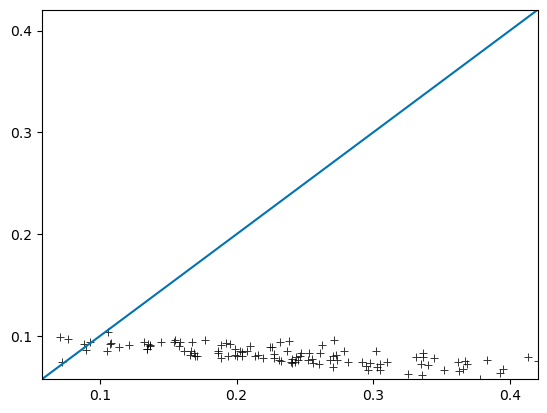

In [14]:
from amn.tools import plot_regression
plot_regression(PRED, TRUE, "", "","")